In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


def create_dataframe():
    # initialize db connection and session
    db_engine, db_session = init_db()

    # query data from the database
    query = db_session.query(
        RacingWeekend.year,
        RacingWeekend.round,
        Circuit.circuit_name,
        Driver.driver_name,
        Driver.driver_short,
        Lap.lap_num,
        Lap.lap_time,
        Lap.tyre,
        Lap.tyre_laps,
        Lap.pit,
        Session.session_type
    ).join(RacingWeekend.circuit) \
     .join(RacingWeekend.sessions) \
     .join(Session.laps) \
     .join(Lap.driver) \
     .join(RacingWeekend.season) \
     .all()

    # convert result to list of dicts
    data = []
    for row in query:
        data.append({
            'year': row.year,
            'round': row.round,
            'circuit_name': row.circuit_name,
            'driver_name': row.driver_name,
            'driver_short': row.driver_short,
            'lap_num': row.lap_num,
            'lap_time': row.lap_time,
            'tyre': row.tyre,
            'tyre_laps': row.tyre_laps,
            'pit': row.pit,
            'session_type': row.session_type
        })

    # create dataframe
    df = pd.DataFrame(data)

    return df


def assign_stint_numbers(df):
    # Assign stint numbers to laps based on pit stops for each driver
    df['stint'] = np.nan
    for driver in df['driver_short'].unique():
        driver_data = df[df['driver_short'] == driver]
        stint_number = 1
        for i in driver_data.index:
            if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
                stint_number += 1
            df.loc[i, 'stint'] = stint_number
    df['stint'] = df['stint'].astype(int)
    return df


def get_last_10_races_from_round(df, year, round_):
    # Get the last 10 unique races starting from a given year and round
    df_unique = df.drop_duplicates(subset=['year', 'round'])
    filtered_df = df_unique[
        (df_unique['year'] < year) | 
        ((df_unique['year'] == year) & (df_unique['round'] <= round_))
    ]
    df_sorted = filtered_df.sort_values(by=['year', 'round'], ascending=[False, False])
    last_10_races = df_sorted[['year', 'round']].head(30)
    return last_10_races


def analyze_and_average_polynomials(df, driver, current_year, current_round):
    # Get the last 10 races starting from the current race
    last_10_races = get_last_10_races_from_round(df, current_year, current_round)
    
    # Store polynomial coefficients for each tyre type across races
    tyre_poly_coeffs = {tyre: [] for tyre in df['tyre'].unique()}
    
    # Loop through each race in the last 10 races
    for _, race in last_10_races.iterrows():
        year = race['year']
        round_ = race['round']
        
        # Filter the DataFrame for the specific race and driver
        race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver)].copy()
        
        # Normalize lap times based on the fastest lap and filter out outliers
        fastest_lap_time = race_df['lap_time'].min()
        race_df = race_df[race_df['lap_time'] <= 1.03 * fastest_lap_time]  # Filter out lap times more than 3% slower
        
        # Calculate the difference from the fastest lap for each lap
        race_df['time_diff'] = race_df['lap_time'] - fastest_lap_time
        
        # Assign stint numbers
        race_df = assign_stint_numbers(race_df)
        
        # Loop over each tyre type and perform polynomial regression for each stint
        for tyre in race_df['tyre'].unique():
            tyre_data = race_df[race_df['tyre'] == tyre]
            
            # Loop through each stint for the given tyre type
            for stint in tyre_data['stint'].unique():
                stint_data = tyre_data[tyre_data['stint'] == stint]
                x = stint_data['tyre_laps']
                y = stint_data['time_diff']
                
                # Polynomial regression (2nd degree)
                if len(x) > 2:
                    poly_coeffs = np.polyfit(x, y, 1)
                    tyre_poly_coeffs[tyre].append(poly_coeffs)
    
    # Average the polynomial coefficients for each tyre type across all races
    averaged_poly_coeffs = {}
    for tyre, poly_coeffs_list in tyre_poly_coeffs.items():
        if poly_coeffs_list:
            avg_poly_coeffs = np.mean(poly_coeffs_list, axis=0)
            averaged_poly_coeffs[tyre] = avg_poly_coeffs
    
    # Return the averaged polynomial equations for each tyre type
    polynomial_equations = {}
    for tyre, coeffs in averaged_poly_coeffs.items():
        equation = f"{coeffs[0]:.3f}x^2 + {coeffs[1]:.3f}x + {coeffs[0]:.3f}"
        polynomial_equations[tyre] = equation
    
    return averaged_poly_coeffs


def get_qualifying_to_race_percentage_difference(df, driver, year, round_, n_races=10):
    """
    Calculate the average percentage difference between the best qualifying lap time and best race lap time
    over the last `n_races` for the given driver.

    Args:
        df (DataFrame): The dataframe containing race and qualifying data.
        driver (str): The driver's name or short identifier.
        year (int): The year of the races.
        round_ (int): The current race round.
        n_races (int): The number of past races to consider (default 10).

    Returns:
        float: The average percentage difference between qualifying and race lap times.
    """
    # Get all races for the given driver, within the last `n_races` rounds
    races_df = df[(df['year'] == year) & (df['driver_short'] == driver)].copy()
    
    # Limit to the last `n_races`
    races_df = races_df[races_df['round'] <= round_].tail(n_races)

    percentage_diffs = []

    for _, race in races_df.iterrows():
        # Get best qualifying lap time for the driver in this round
        quali_df = df[(df['year'] == race['year']) & 
                      (df['round'] == race['round']) & 
                      (df['driver_short'] == driver) & 
                      (df['session_type'] == 'Qualifying')]
        fastest_quali_time = quali_df['lap_time'].min() if not quali_df.empty else None

        # Get best race lap time for the driver in this round
        race_df = df[(df['year'] == race['year']) & 
                     (df['round'] == race['round']) & 
                     (df['driver_short'] == driver) & 
                     (df['session_type'] == 'Race')]
        fastest_race_time = race_df['lap_time'].min() if not race_df.empty else None

        # If both quali and race lap times are available, calculate the percentage difference
        if fastest_quali_time and fastest_race_time:
            diff = (fastest_race_time - fastest_quali_time) / fastest_quali_time * 100
            percentage_diffs.append(diff)

    # Return the average percentage difference, or 0 if no valid data
    return np.mean(percentage_diffs) if percentage_diffs else 0


def predict_lap_time(df, driver, year, round_, polynomial_equations):
    # Get the race data for the given driver and race
    race_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver) & (df['session_type'] == 'Race')].copy()

    # Get the best qualifying lap time for the driver in the same round
    quali_df = df[(df['year'] == year) & (df['round'] == round_) & (df['driver_short'] == driver) & (df['session_type'] == 'Qualifying')].copy()
    fastest_quali_time = quali_df['lap_time'].min() if not quali_df.empty else None

    if fastest_quali_time is None:
        raise ValueError(f"No qualifying lap time found for driver {driver} in {year} round {round_}")

    # Get the average percentage difference between quali and race times over the last 10 races
    avg_percentage_diff = get_qualifying_to_race_percentage_difference(df, driver, year, round_)

    # Adjust the fastest qualifying time based on the average percentage difference
    base_laptime = fastest_quali_time * (1 + avg_percentage_diff / 100)

    # Iterate through each lap in the race
    predicted_lap_times = []
    for index, row in race_df.iterrows():
        # Get the tire type and laps on the tire for the current lap
        tyre_type = row['tyre']
        tyre_laps = row['tyre_laps']  # Number of laps the driver has been on this tire
        
        # Check if a polynomial equation exists for this tire type
        if tyre_type in polynomial_equations:
            # Use the polynomial equation to predict the time difference from the fastest lap for the given number of laps
            predicted_time_diff = np.polyval(polynomial_equations[tyre_type], tyre_laps)

            # Predict the lap time by adding the time difference to the base lap time
            predicted_time = predicted_time_diff + base_laptime
            race_df.at[index, 'predicted_time'] = predicted_time

    return race_df


# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=2023, current_round=11)
print(polynomial_equations)

# Predict lap times for the 2023, round 13 for the driver
predicted_lap_times = predict_lap_time(df, driver='NOR', year=2023, round_=13, polynomial_equations=polynomial_equations)

# Print the predicted lap times for the 13th race
(predicted_lap_times[['lap_num', 'lap_time', 'predicted_time']])

/tmp/ipykernel_84361/3128454139.py:126: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x, y, 1)


{np.int64(1): array([0.14868448, 0.45932595]), np.int64(2): array([-0.01712087,  1.96598373]), np.int64(3): array([0.12136628, 1.60479651])}


,lap_num,lap_time,predicted_time
221801,1,92.227,74.998010
221802,2,107.848,75.146695
221803,3,115.144,75.295379
221804,4,107.537,NaN
221805,5,83.686,NaN
...,...,...,...
221866,68,84.530,NaN
221867,69,82.506,NaN
221868,70,82.490,NaN
221869,71,82.130,NaN


/tmp/ipykernel_84361/3128454139.py:126: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x, y, 1)


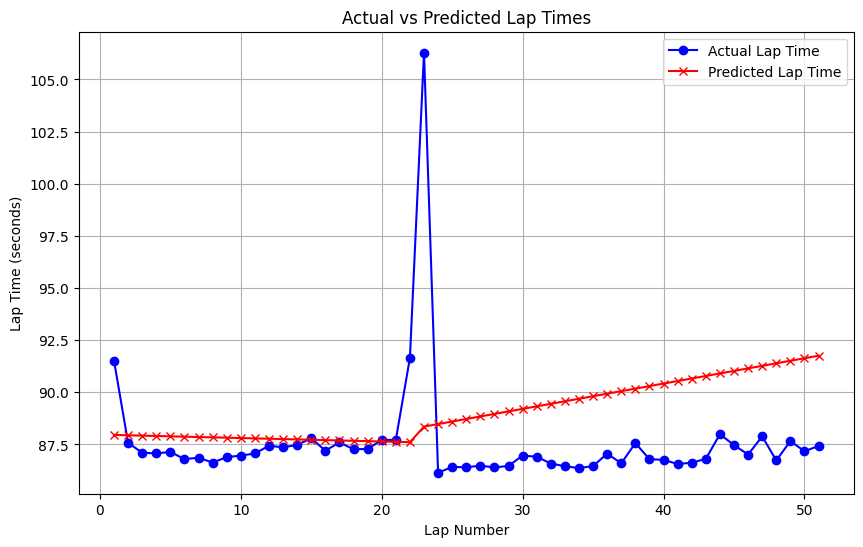

In [20]:
import matplotlib.pyplot as plt

def plot_lap_times(race_df):
	# Plotting actual vs predicted lap times
	plt.figure(figsize=(10, 6))

	# Plot actual lap times
	plt.plot(race_df['lap_num'], race_df['lap_time'], label='Actual Lap Time', color='blue', marker='o')

	# Plot predicted lap times
	plt.plot(race_df['lap_num'], race_df['predicted_time'], label='Predicted Lap Time', color='red', marker='x')

	# Adding labels and title
	plt.xlabel('Lap Number')
	plt.ylabel('Lap Time (seconds)')
	plt.title('Actual vs Predicted Lap Times')
	
	# Add legend
	plt.legend()

	# Show the plot
	plt.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=2023, current_round=13)

# Predict lap times for the 2023, round 13 for the driver
predicted_lap_times = predict_lap_time(df, driver='NOR', year=2023, round_=14, polynomial_equations=polynomial_equations)

# Plot the actual and predicted lap times
plot_lap_times(predicted_lap_times)


/tmp/ipykernel_84361/3128454139.py:126: RankWarning: Polyfit may be poorly conditioned
  poly_coeffs = np.polyfit(x, y, 1)


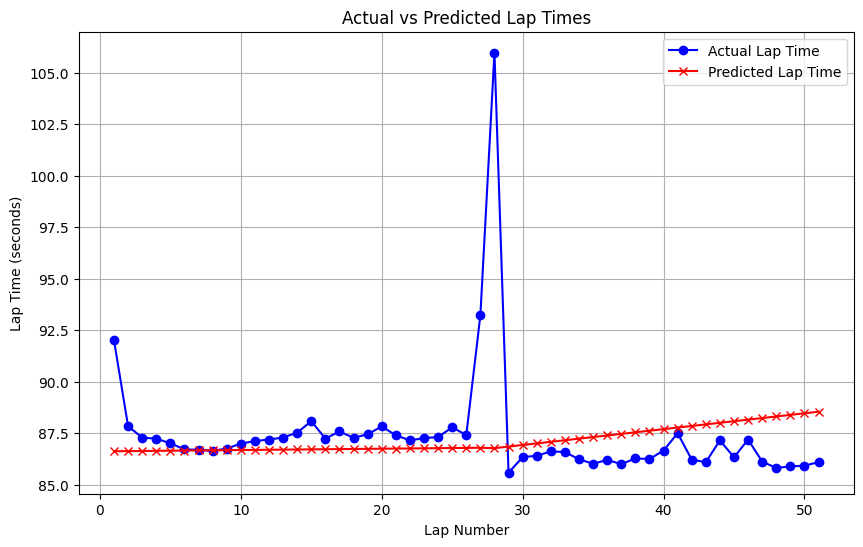

In [21]:
import matplotlib.pyplot as plt

def plot_lap_times(race_df):
	# Plotting actual vs predicted lap times
	plt.figure(figsize=(10, 6))

	# Plot actual lap times
	plt.plot(race_df['lap_num'], race_df['lap_time'], label='Actual Lap Time', color='blue', marker='o')

	# Plot predicted lap times
	plt.plot(race_df['lap_num'], race_df['predicted_time'], label='Predicted Lap Time', color='red', marker='x')

	# Adding labels and title
	plt.xlabel('Lap Number')
	plt.ylabel('Lap Time (seconds)')
	plt.title('Actual vs Predicted Lap Times')
	
	# Add legend
	plt.legend()

	# Show the plot
	plt.grid(True)
	plt.show()

# Example usage
df = create_dataframe()

# Load polynomial equations for the driver (from analyze_and_average_polynomials function)
polynomial_equations = analyze_and_average_polynomials(df, driver='HAM', current_year=2023, current_round=13)

# Predict lap times for the 2023, round 13 for the driver
predicted_lap_times = predict_lap_time(df, driver='HAM', year=2023, round_=14, polynomial_equations=polynomial_equations)

# Plot the actual and predicted lap times
plot_lap_times(predicted_lap_times)


Mean Squared Error (MSE): 777772.8239554109


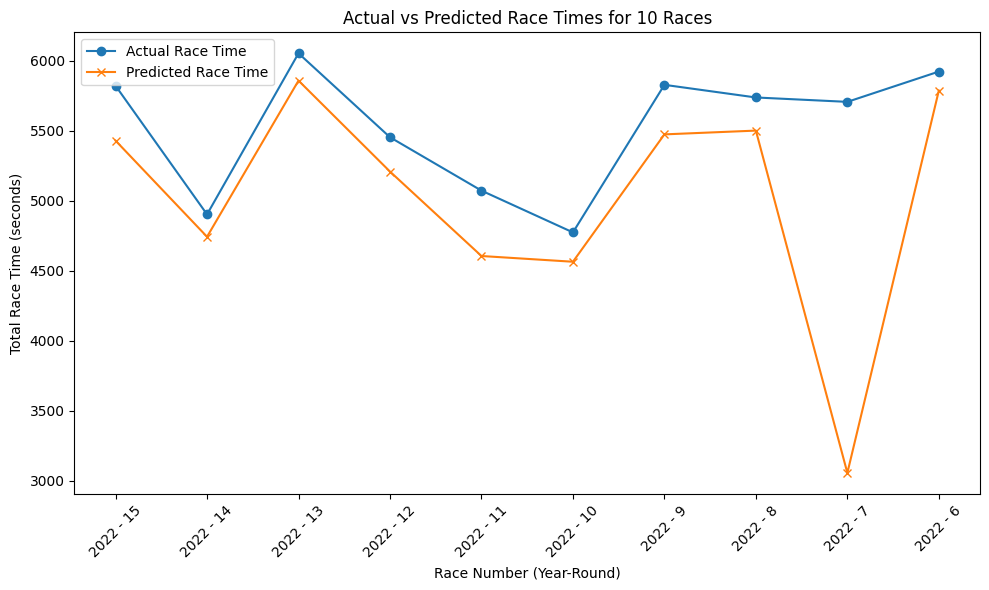

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def predict_lap_time_for_multiple_races(df, start_year, start_round, polynomial_equations, n_races=10):

    # List to store actual and predicted times for each race
    actual_times = []
    predicted_times = []
    race_numbers = []

    current_year = start_year
    current_round = start_round

    # Loop through each race from start_year, start_round for n_races races
    for race in range(n_races):
        polynomial_equations = analyze_and_average_polynomials(df, driver='NOR', current_year=current_year, current_round=current_round-1)

        # Filter race data
        race_df = df[(df['year'] == current_year) & (df['round'] == current_round) & (df['session_type'] == 'Race') & (df['driver_short'] == "NOR")]

        if race_df.empty:
            print(f"No race data found for {current_year} round {current_round}. Skipping.")
            continue

        # Get the actual lap times
        actual_race_time = race_df['lap_time'].sum()  # sum of lap times for the race

        # Predict lap times using the polynomial equations
        predicted_race_df = predict_lap_time(df, driver='NOR', year=current_year, round_=current_round, polynomial_equations=polynomial_equations)
        predicted_race_time = predicted_race_df['predicted_time'].sum()  # sum of predicted lap times for the race

        # Append actual and predicted times to the lists
        actual_times.append(actual_race_time)
        predicted_times.append(predicted_race_time)
        race_numbers.append(f"{current_year} - {current_round}")

        # Update for the next race
        current_round -= 1


    return race_numbers, actual_times, predicted_times


# Test the method and plot
race_numbers, actual_times, predicted_times = predict_lap_time_for_multiple_races(df, start_year=2022, start_round=15, polynomial_equations=polynomial_equations)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(actual_times, predicted_times)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the total actual vs predicted race times
plt.figure(figsize=(10, 6))
plt.plot(race_numbers, actual_times, label='Actual Race Time', marker='o')
plt.plot(race_numbers, predicted_times, label='Predicted Race Time', marker='x')
plt.xlabel('Race Number (Year-Round)')
plt.ylabel('Total Race Time (seconds)')
plt.title('Actual vs Predicted Race Times for 10 Races')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()